Based on:
https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54


# Install packages

In [1]:
!pip install plot_keras_history
!pip install keras
!pip uninstall  -y
!pip install tensorflow==2.3.0
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install pydot
!pip install numpy --upgrade

You should consider upgrading via the '/home/digitalhub/.pyenv/versions/3.8.12/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/digitalhub/.pyenv/versions/3.8.12/bin/python3.8 -m pip install --upgrade pip' command.
ERROR: You must give at least one requirement to uninstall (see "pip help uninstall")
  Using cached numpy-1.18.5-cp38-cp38-manylinux1_x86_64.whl (20.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.7.0 requires keras<2.8,>=2.7.0rc0, but you have keras 2.3.1 which is incompatible.
tensorflow-gpu 2.7.0 requires tensorflow-estimator<2.8,~=2.7.0rc0, but you have tensorflow-estimator 2.3.0 which is incompatible.
matplotlib 3.6.2 require

# Import packages

In [2]:
import re
import pickle
import string
import operator
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy.random import seed
from plot_keras_history import plot_history

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

from keras_contrib import losses
from keras_contrib import metrics
from keras_contrib.layers import CRF
from keras_contrib.utils import save_load_utils


2022-12-07 09:54:15.241511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-07 09:54:15.241525: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using TensorFlow backend.


# GMB data



## Import and preprocess general data

In [3]:
#Download Groningen Meaning Bank (GMB) data: https://gmb.let.rug.nl/about.php for baseline
train_path = 'ner_data/ner_dataset.csv'
bl_data = pd.read_csv(train_path, encoding="iso-8859-1", header=0)
bl_data.drop(columns=['POS'])

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O
...,...,...,...
1048570,NaN,they,O
1048571,NaN,responded,O
1048572,NaN,to,O
1048573,NaN,the,O


In [4]:
print("Total number of sentences in the dataset: {:,}".format(bl_data["Sentence #"].nunique()))
print("Total words in the dataset: {:,}".format(bl_data.shape[0]))

Total number of sentences in the dataset: 47,959
Total words in the dataset: 1,048,575


In [5]:
bl_data.ffill(inplace=True) #forward fill sentence column
bl_data['Sentence #'] = bl_data['Sentence #'].apply(lambda i: i[9:]) #reformat sentence column
bl_data["Sentence #"] = bl_data["Sentence #"].astype("int32") #change sentence column type
bl_data.rename(columns = {'Sentence #':'Sentence'}, inplace = True)

In [6]:
#Function to get dictionary of all unique items ('Word' and 'Tag')
#Returns 1 dictionary of index:item pairs and 1 dictionary of item:index pairs
def get_dict_map(data, column):
    item2idx = {}
    idx2item = {}
    
    corpus = list(set(data[column].to_list())) #get list of unique words/tags

    idx2item = {index:item for index, item in enumerate(corpus)}
    item2idx = {item:index for index, item in enumerate(corpus)}
    
    return idx2item, item2idx

In [7]:
def group_data(data, word2idx, tag2idx):

  #Create index columns for 'Word' and 'Tag'
  data['Word_index'] = data['Word'].map(word2idx)
  data['Tag_index'] = data['Tag'].map(tag2idx)

  #For each sentence, create a sequence of words, pos, tags, word indexes, tag indexes
  data_group = data.groupby(['Sentence'],as_index=False)['Word', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))
  return data_group

In [8]:
  #Get index to word, word to index, index to tag, tag to index mapping
  idx2word, word2idx = get_dict_map(bl_data, 'Word')
  idx2tag, tag2idx = get_dict_map(bl_data, 'Tag')

In [9]:
bl_data_group = group_data(bl_data, word2idx, tag2idx)

/tmp/ipykernel_6612/3682637150.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_group = data.groupby(['Sentence'],as_index=False)['Word', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))


## Prepare train and test data


In [10]:
def get_pad_train_test_val(data_group, data):

    #total num of unique words and tags
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad Words (X var)    
    words = data_group['Word_index'].tolist()
    maxlen = max([len(word) for word in words])
    pad_tokens = pad_sequences(words, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_index'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags] #one hot encoding
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_words length:', len(train_tokens),
        '\ntrain_tags length:', len(train_tags),
        '\nval_words:', len(val_tokens),
        '\nval_tags:', len(val_tags),
        '\ntest_words length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),

    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

In [11]:
train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(bl_data_group, bl_data)

train_words length: 32372 
train_tags length: 32372 
val_words: 10791 
val_tags: 10791 
test_words length: 4796 
test_tags: 4796


## Model

In [12]:
seed(1)
tf.random.set_seed(2)

In [13]:
input_dim = len(list(set(bl_data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in bl_data_group['Word_index'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  64 
input_length:  104 
n_tags:  17


In [14]:
#Function to initialise and structure NN architecture
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [15]:
#Function to train model, returns list of losses for each epoch
def train_model(X, y, model):
    loss = list()
    for i in range(25): #run 25 epochs in total
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

In [16]:
results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

2022-12-07 09:54:20.659163: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-07 09:54:20.659249: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dh-minion2): /proc/driver/nvidia/version does not exist
2022-12-07 09:54:20.660610: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 64)           2251456   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 128)          66048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 64)           49408     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           1105      
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
26/26 [==============================] - 23s 889ms/step - loss: 0.0779 - a

In [17]:
#Visualise model architecture
plot_model(model_bilstm_lstm)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


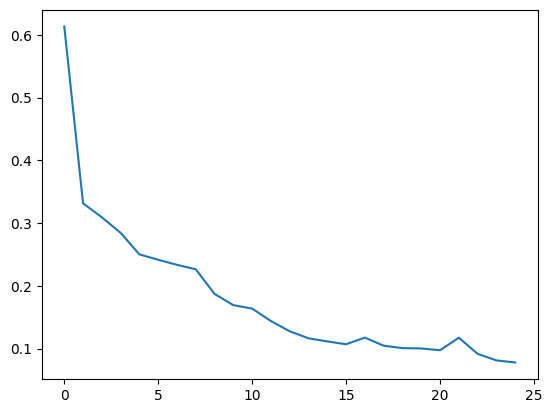

In [18]:
#Visualise loss curve of 25 epochs
plt.plot(results['with_add_lstm'])

## Results

In [19]:
y_pred = model_bilstm_lstm.predict(test_tokens)

y_pred = np.argmax(y_pred, axis=2)

y_test = np.argmax(test_tags, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy/Micro-f1/Micro-precision/Micro-recall: {:.4f}".format(accuracy))

Accuracy/Micro-f1/Micro-precision/Micro-recall: 0.9718


In [20]:
def tag_conf_matrix(cm, tagid):
    tag_name = idx2tag[tagid]
    #print("Tag name: {}".format(tag_name))
    #print(cm[tagid])
    tn, fp, fn, tp = cm[tagid].ravel()
    tag_acc = (tp + tn) / (tn + fp + fn + tp)
    tag_pre = tp / (tp + fp)
    tag_rec = tp / (tp + fn)
    tag_f1 = 2*(tag_pre * tag_rec)/(tag_pre + tag_rec)
    #print("Tag accuracy: {:.3f} \n".format(tag_acc))
    #print("Tag precision: {:.3f} \n".format(tag_pre))
    #print("Tag recall: {:.3f} \n".format(tag_rec))
    #print("Tag f1: {:.3f} \n".format(tag_f1))

    return tag_acc, tag_pre, tag_rec, tag_f1


In [21]:
def macro_f1(cm):
    f1_list = []
    for i in range(0, 17): #for every class
        tag_acc, tag_pre, tag_rec, tag_f1 = tag_conf_matrix(cm, i)
        f1_list.append(tag_f1)
    score = np.nanmean(f1_list)
    return score

In [22]:
cm = multilabel_confusion_matrix(y_test.flatten(), y_pred.flatten())
macro_f1(cm)

/tmp/ipykernel_6612/1659057365.py:7: RuntimeWarning: invalid value encountered in long_scalars
  tag_pre = tp / (tp + fp)
/tmp/ipykernel_6612/1659057365.py:9: RuntimeWarning: invalid value encountered in double_scalars
  tag_f1 = 2*(tag_pre * tag_rec)/(tag_pre + tag_rec)


0.31720388861667326

In [23]:
#for i in range(0, 17):
    #tag_acc, tag_pre, tag_rec, tag_f1 = tag_conf_matrix(cm, i)
    #print(tag_f1)

nan
nan
nan
nan
0.00851063829787234
0.24114397140071497
0.3087621696801113
nan
nan
0.08622754491017964
nan
nan
0.18515997277059226
0.19558359621451105
0.28023598820059
0.9869847245808037
0.5622263914946841


/tmp/ipykernel_6612/1659057365.py:7: RuntimeWarning: invalid value encountered in long_scalars
  tag_pre = tp / (tp + fp)
/tmp/ipykernel_6612/1659057365.py:9: RuntimeWarning: invalid value encountered in double_scalars
  tag_f1 = 2*(tag_pre * tag_rec)/(tag_pre + tag_rec)


# Re3d data

## Import and preprocess domain-specific model

In [24]:
#Prepare dataframe from text file
def prepare_data(path):
  data = pd.DataFrame(columns=['Sentence', 'Word', 'Tag'])
  with open(path) as f:
    sentence = 0
    for line in f:
      if line == '\n':
        sentence += 1
      else:
        split = line.split("\t")
        word = split[0]
        tag = split[1].strip()
        new_row = {'Sentence': sentence, 'Word': word, 'Tag': tag}
        data = data.append(new_row, ignore_index=True)
  return data

In [25]:
train_path = 'entity-recognition-datasets-master/data/re3d/CONLL-format/data/train/re3d-train.conll'
train_df = prepare_data(train_path)
test_path = 'entity-recognition-datasets-master/data/re3d/CONLL-format/data/test/re3d-test.conll'
test_df = prepare_data(test_path)

#train_df = pd.to_csv('')

In [26]:
ds_data = pd.concat([train_df, test_df])

In [27]:
#Get index to word, word to index, index to tag, tag to index mapping
idx2word, word2idx = get_dict_map(ds_data, 'Word')
idx2tag, tag2idx = get_dict_map(ds_data, 'Tag')

In [28]:
ds_data_group = group_data(ds_data, word2idx, tag2idx)

/tmp/ipykernel_6612/3682637150.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_group = data.groupby(['Sentence'],as_index=False)['Word', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))


## Prepare data

In [29]:
#train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(ds_data_group, ds_data)

In [30]:
def get_pad_train_test(data_group, data):

    #total num of unique words and tags
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad Words (X var)    
    words = data_group['Word_index'].tolist()
    maxlen = max([len(word) for word in words])
    pad_tokens = pad_sequences(words, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_index'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags] #one hot encoding
    
    #Split train, test and validation set
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_words length:', len(train_tokens),
        '\ntrain_tags length:', len(train_tags),
        '\ntest_words length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),

    )
    
    return train_tokens, test_tokens, train_tags, test_tags

In [31]:
train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test(ds_data_group, ds_data)

train_words length: 688 
train_tags length: 688 
test_words length: 77 
test_tags: 77


## Model

In [32]:
seed(1)
tf.random.set_seed(2)

In [33]:
input_dim = len(list(set(ds_data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in ds_data_group['Word_index'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  4295 
output_dim:  64 
input_length:  154 
n_tags:  21


In [34]:
#Function to initialise and structure NN architecture
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [35]:
#Function to train model, returns list of losses for each epoch
def train_model(X, y, model):
    loss = list()
    for i in range(25): #run 25 epochs in total
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.1)
        loss.append(hist.history['loss'][0])
    return loss

In [36]:
results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 154, 64)           274880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 154, 128)          66048     
_________________________________________________________________
lstm_3 (LSTM)                (None, 154, 64)           49408     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 154, 21)           1365      
Total params: 391,701
Trainable params: 391,701
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
1/1 [==============================] - 1s 810ms/step - loss: 0.4100 - accura

In [ ]:
plt.plot(results['with_add_lstm'])

## Results

In [37]:
y_pred = model_bilstm_lstm.predict(test_tokens)

y_pred = np.argmax(y_pred, axis=2)

y_test = np.argmax(test_tags, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy/Micro-f1/Micro-precision/Micro-recall: {:.4f}".format(accuracy))

Accuracy/Micro-f1/Micro-precision/Micro-recall: 0.9440


In [38]:
def tag_conf_matrix(cm, tagid):
    tag_name = idx2tag[tagid]
    #print("Tag name: {}".format(tag_name))
    #print(cm[tagid])
    tn, fp, fn, tp = cm[tagid].ravel()
    tag_acc = (tp + tn) / (tn + fp + fn + tp)
    tag_pre = tp / (tp + fp)
    tag_rec = tp / (tp + fn)
    tag_f1 = 2*(tag_pre * tag_rec)/(tag_pre + tag_rec)
    #print("Tag accuracy: {:.3f} \n".format(tag_acc))
    #print("Tag precision: {:.3f} \n".format(tag_pre))
    #print("Tag recall: {:.3f} \n".format(tag_rec))
    #print("Tag f1: {:.3f} \n".format(tag_f1))

    return tag_acc, tag_pre, tag_rec, tag_f1


In [39]:
idx2tag

{0: 'B-Temporal',
 1: 'I-Location',
 2: 'I-DocumentReference',
 3: 'B-MilitaryPlatform',
 4: 'I-Person',
 5: 'I-Nationality',
 6: 'I-Weapon',
 7: 'I-Organisation',
 8: 'I-MilitaryPlatform',
 9: 'B-Location',
 10: 'I-Temporal',
 11: 'B-Organisation',
 12: 'B-DocumentReference',
 13: 'B-Quantity',
 14: 'I-Money',
 15: 'B-Weapon',
 16: 'B-Person',
 17: 'I-Quantity',
 18: 'B-Money',
 19: 'B-Nationality',
 20: 'O'}

In [40]:
def macro_f1(cm):
    f1_list = []
    for i in range(0, 20): #for every class
        tag_acc, tag_pre, tag_rec, tag_f1 = tag_conf_matrix(cm, i)
        f1_list.append(tag_f1)
    score = np.nanmean(f1_list)
    return score

In [41]:
cm = multilabel_confusion_matrix(y_test.flatten(), y_pred.flatten())
macro_f1(cm)

/tmp/ipykernel_6612/1659057365.py:7: RuntimeWarning: invalid value encountered in long_scalars
  tag_pre = tp / (tp + fp)
/tmp/ipykernel_6612/1659057365.py:9: RuntimeWarning: invalid value encountered in double_scalars
  tag_f1 = 2*(tag_pre * tag_rec)/(tag_pre + tag_rec)


0.9712798264642083

# DOCRED data

## Import and preprocess domain-specific model

In [42]:
#Prepare dataframe from text file
def prepare_data(path):
  data = pd.DataFrame(columns=['Sentence', 'Word', 'Tag'])
  with open(path) as f:
    sentence = 0
    for line in f:
      if line == '\n':
        sentence += 1
      else:
        split = line.split("\t")
        word = split[0]
        tag = split[1].strip()
        new_row = {'Sentence': sentence, 'Word': word, 'Tag': tag}
        data = data.append(new_row, ignore_index=True)
  return data

In [43]:
#Converting text file (in conll format) to dataframe
#Just run once

#dev_path = 'docred_preprocessed/dev.txt'
#dev_df = prepare_data(dev_path)
#dev_df.to_csv('dev_df.csv')

#test_path = 'docred_preprocessed/test.txt'
#test_df = prepare_data(test_path)
#test_df.to_csv('test_df.csv')

#train_path = 'docred_preprocessed/train.txt'
#train_df = prepare_data(train_path)
#train_df.to_csv('train_df.csv')

In [44]:
train_df = pd.read_csv('train_df.csv')
dev_df = pd.read_csv('dev_df.csv')
test_df = pd.read_csv('test_df.csv')

In [45]:
ds_data = pd.concat([train_df, test_df])
ds_data = pd.concat([ds_data, dev_df])

In [46]:
#Get index to word, word to index, index to tag, tag to index mapping
idx2word, word2idx = get_dict_map(ds_data, 'Word')
idx2tag, tag2idx = get_dict_map(ds_data, 'Tag')

In [47]:
ds_data_group = group_data(ds_data, word2idx, tag2idx)

/tmp/ipykernel_6612/3682637150.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_group = data.groupby(['Sentence'],as_index=False)['Word', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))


In [48]:
ds_data_group.shape

(3008, 5)

In [49]:
ds_data_group = ds_data_group.head(700)

## Prepare data

In [50]:
#train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(ds_data_group, ds_data)

In [51]:
def get_pad_train_test(data_group, data):

    #total num of unique words and tags
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad Words (X var)    
    words = data_group['Word_index'].tolist()
    maxlen = max([len(word) for word in words])
    pad_tokens = pad_sequences(words, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_index'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags] #one hot encoding
    
    #Split train, test and validation set
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_words length:', len(train_tokens),
        '\ntrain_tags length:', len(train_tags),
        '\ntest_words length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),

    )
    
    return train_tokens, test_tokens, train_tags, test_tags

In [52]:
train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test(ds_data_group, ds_data)

train_words length: 630 
train_tags length: 630 
test_words length: 70 
test_tags: 70


## Model

In [53]:
seed(1)
tf.random.set_seed(2)

In [54]:
input_dim = len(list(set(ds_data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in ds_data_group['Word_index'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  32744 
output_dim:  64 
input_length:  1246 
n_tags:  13


In [75]:
#Function to initialise and structure NN architecture
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    #adam = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [76]:
#Function to train model, returns list of losses for each epoch
def train_model(X, y, model):
    loss = list()
    for i in range(25): #run 25 epochs in total
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=10, verbose=1, epochs=1, validation_split=0.1)
        loss.append(hist.history['loss'][0])
    return loss

In [77]:
results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1246, 64)          2095616   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 1246, 128)         66048     
_________________________________________________________________
lstm_11 (LSTM)               (None, 1246, 64)          49408     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1246, 13)          845       
Total params: 2,211,917
Trainable params: 2,211,917
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
57/57 [==============================] - 66s 1s/step - loss: 0.1266 - ac

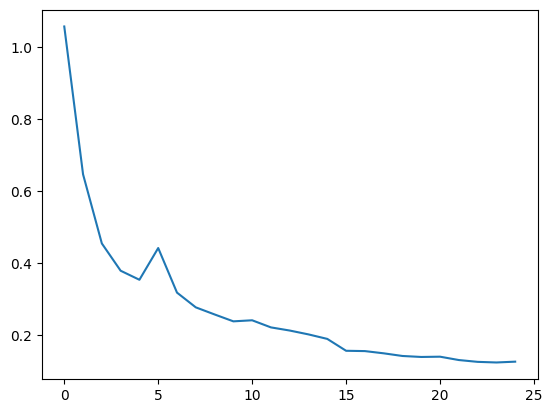

In [85]:
plt.plot(results['with_add_lstm'])

## Results

In [78]:
y_pred = model_bilstm_lstm.predict(test_tokens)

y_pred = np.argmax(y_pred, axis=2)

y_test = np.argmax(test_tags, axis=2)

accuracy = (y_pred == y_test).mean() #change from true/false to numerical proportion

print("Accuracy/Micro-f1/Micro-precision/Micro-recall: {:.4f}".format(accuracy))

Accuracy/Micro-f1/Micro-precision/Micro-recall: 0.9404


In [79]:
def tag_conf_matrix(cm, tagid):
    tag_name = idx2tag[tagid]
    #print("Tag name: {}".format(tag_name))
    #print(cm[tagid])
    tn, fp, fn, tp = cm[tagid].ravel()
    tag_acc = (tp + tn) / (tn + fp + fn + tp)
    tag_pre = tp / (tp + fp)
    tag_rec = tp / (tp + fn)
    tag_f1 = 2*(tag_pre * tag_rec)/(tag_pre + tag_rec)
    #print("Tag accuracy: {:.3f} \n".format(tag_acc))
    #print("Tag precision: {:.3f} \n".format(tag_pre))
    #print("Tag recall: {:.3f} \n".format(tag_rec))
    #print("Tag f1: {:.3f} \n".format(tag_f1))

    return tag_acc, tag_pre, tag_rec, tag_f1


In [80]:
idx2tag

{0: 'B-PER',
 1: 'B-LOC',
 2: 'B-TIME',
 3: 'B-MISC',
 4: 'I-LOC',
 5: 'I-MISC',
 6: 'I-ORG',
 7: 'B-NUM',
 8: 'I-TIME',
 9: 'I-NUM',
 10: 'I-PER',
 11: 'B-ORG',
 12: 'O'}

In [83]:
def macro_f1(cm):
    f1_list = []
    for i in range(0, 11): #for every class
        _, _, _, tag_f1 = tag_conf_matrix(cm, i)
        f1_list.append(tag_f1)
    score = np.nanmean(f1_list)
    return score

In [84]:
cm = multilabel_confusion_matrix(y_test.flatten(), y_pred.flatten())
macro_f1(cm)

/tmp/ipykernel_6612/1659057365.py:7: RuntimeWarning: invalid value encountered in long_scalars
  tag_pre = tp / (tp + fp)


0.22539630389930193